In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pathlib
import zipfile
from glob import glob
import tqdm as notebook_tqdm

import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import xarray as xr
import requests

import matplotlib.pyplot as plt
import hvplot.pandas
import hvplot.xarray
import cartopy.crs as ccrs
import geoviews as gv

import earthaccess

In [3]:
# Base project folder
project_dir = os.path.join(pathlib.Path.home(), 'habitat-suitability')

# Subfolders
plots_dir = os.path.join(project_dir, 'plots')
datasets_dir = os.path.join(project_dir, 'datasets')
data_dir = os.path.join(project_dir, 'data')

# Define directories for data
land_units_dir = os.path.join(data_dir, 'usfs-national-lands')
bh_elevation_dir = os.path.join(data_dir, 'srtm', 'black hills')
bg_elevation_dir = os.path.join(data_dir, 'srtm', 'buffalo gap')

# Create folders if they don't exist
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

print(f"Project folders are ready at {project_dir}!")

Project folders are ready at C:\Users\Justina\habitat-suitability!


In [5]:
import earthaccess

# This will open a browser window and ask for your NASA Earthdata login
earthaccess.login(strategy="interactive", persist=True)


In [7]:
# Search for Digital Elevation Models

ea_dem = earthaccess.search_datasets(keyword='SRTM DEM', count=15)
for dataset in ea_dem:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
NASADEM_NC NASADEM Merged DEM Global 1 arc second nc V001
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
SRTMGL3S NASA Shuttle Radar Topography Mission Global 3 arc second sub-sampled V003
SRTMIMGR NASA Shut

In [9]:
def select_dem(bounds, site_gdf, download_dir):
    """
    Create elevation DataArray from NASA Shuttle Radar Topography Mission data.

    Args:
    bounds (tuple): Input site boundaries.
    site_gdf (geopandas.GeoDataFrame): Land unit GeoDataFrame.
    download_dir (str): Path of download directory.

    Returns:
    xarray.DataArray: A site elevation raster.
    """

    # Returns data granules for given bounds
    strm_granules = earthaccess.search_data(
        # SRTMGL1: NASA Shuttle Radar Topography Mission 
        # Global 1 arc second V003
        short_name="SRTMGL1",
        bounding_box=bounds
    )

    # Download data granules
    earthaccess.download(strm_granules, download_dir)

    # Set SRTM data dir. hgt = height 
    strm_pattern = os.path.join(download_dir, '*.hgt.zip')

    # Build merged elevation DataArray
    strm_da = build_da(glob(strm_pattern), tuple(site_gdf.total_bounds))

    return strm_da


In [21]:
# Open the DEM
with rasterio.open(dem_path) as src:
    bounds = src.bounds  # Get the geographic bounds
    crs = src.crs        # Get the coordinate reference system (CRS)

print("Bounds:", bounds)
print("CRS:", crs)

Bounds: BoundingBox(left=583000.0, bottom=4795000.0, right=584000.0, top=4796000.0)
CRS: EPSG:6342


In [49]:
from rasterio.transform import from_origin

# Create a new profile for the subset with the same metadata as the original DEM
new_profile = profile.copy()
new_profile.update({
    'count': 1,  # Only one band (since we're dealing with a subset of the DEM)
    'width': dem_subset.shape[1],
    'height': dem_subset.shape[0],
    'transform': from_origin(src.bounds[0], src.bounds[3], src.res[0], src.res[1]),  # Top-left corner & resolution
})

# Save the subset to a new file
output_path = "subset_dem.tif"
with rasterio.open(output_path, 'w', **new_profile) as dst:
    dst.write(dem_subset, 1)

print(f"Subset DEM saved to {output_path}")


Subset DEM saved to subset_dem.tif


In [51]:
import rasterio
from rasterio.transform import from_origin

# Set up the transform (where this subset starts)
transform = from_origin(
    profile['transform'][2] + col_min * profile['transform'][0],
    profile['transform'][5] + row_min * profile['transform'][4],
    profile['transform'][0],
    profile['transform'][4]
)

# Create a new profile
subset_profile = profile.copy()
subset_profile.update({
    'height': dem_subset.shape[0],
    'width': dem_subset.shape[1],
    'transform': transform
})

# Save the subset
with rasterio.open('subset_dem.tif', 'w', **subset_profile) as dst:
    dst.write(dem_subset, 1)



In [65]:
import pandas as pd

# Load your data (if not loaded yet)
buffalograss_df = pd.read_csv(r"C:\Users\Justina\habitat-suitability\data\cleaned_south_dakota_buffalograss_data.csv")

# 1. Look at the first few rows
print(buffalograss_df.head())

# 2. See all column names
print(buffalograss_df.columns)

# 3. See basic info about the dataset
print(buffalograss_df.info())


  Plant ID        Country         State  State FIP       County  County FIP
0    BODA2  United States  South Dakota         46          NaN         NaN
1    BODA2  United States  South Dakota         46       Aurora         3.0
2    BODA2  United States  South Dakota         46    Brookings        11.0
3    BODA2  United States  South Dakota         46        Brule        15.0
4    BODA2  United States  South Dakota         46  Charles Mix        23.0
Index(['Plant ID', 'Country', 'State', 'State FIP', 'County', 'County FIP'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Plant ID    20 non-null     object 
 1   Country     20 non-null     object 
 2   State       20 non-null     object 
 3   State FIP   20 non-null     int64  
 4   County      19 non-null     object 
 5   County FIP  19 non-null     float64
dtypes: float64(1), i

In [67]:
# Load your data (if not loaded yet)
pr_df = pd.read_csv(r"C:\Users\Justina\habitat-suitability\data\cleaned_PRISM.csv")

# 1. Look at the first few rows
print(pr_df.head())

# 2. See all column names
print(pr_df.columns)

# 3. See basic info about the dataset
print(pr_df.info())

      Month  ppt (inches)  tmean (degrees F)
0   January          0.38               16.7
1  February          0.57               20.3
2     March          0.88               31.5
3     April          1.72               44.0
4       May          2.99               55.7
Index(['Month', 'ppt (inches)', 'tmean (degrees F)'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              13 non-null     object 
 1   ppt (inches)       13 non-null     float64
 2   tmean (degrees F)  13 non-null     float64
dtypes: float64(2), object(1)
memory usage: 444.0+ bytes
None


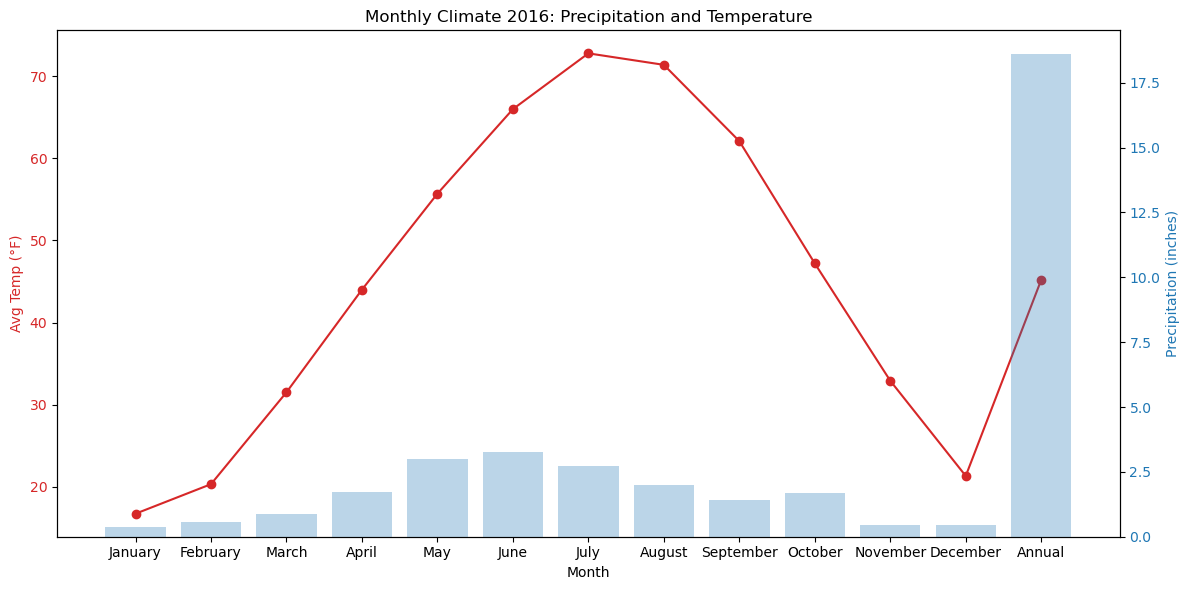

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Load PRISM data
prism = pd.read_csv(r"C:\Users\Justina\habitat-suitability\data\cleaned_PRISM.csv")

# Plot temperature and precipitation
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature (line)
color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Avg Temp (°F)', color=color)
ax1.plot(prism['Month'], prism['tmean (degrees F)'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Plot precipitation (bar) on second y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Precipitation (inches)', color=color)
ax2.bar(prism['Month'], prism['ppt (inches)'], alpha=0.3, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Monthly Climate 2016: Precipitation and Temperature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


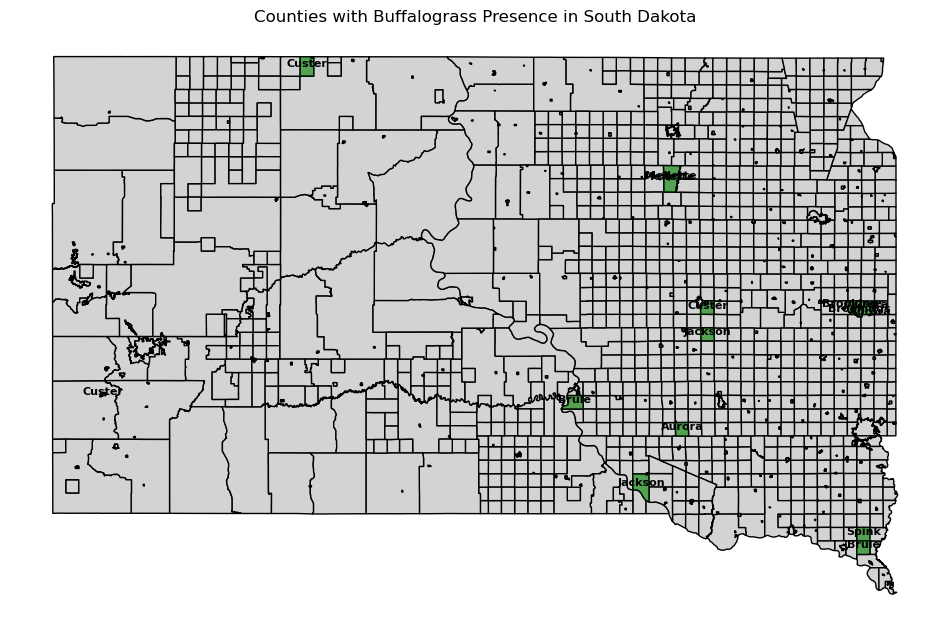

In [123]:
# Load the buffalograss data
buffalo_df = pd.read_csv(r"C:\Users\Justina\habitat-suitability\data\cleaned_south_dakota_buffalograss_data.csv")

# Load the South Dakota counties shapefile
counties = gpd.read_file(r"C:\Users\Justina\habitat-suitability\data\cb_2022_46_cousub_500k.shp")

# Merge the shapefile with your buffalo data
merged = counties.merge(buffalo_df, left_on='NAME', right_on='County')

# Plot the map
fig, ax = plt.subplots(figsize=(12, 10))

# Plot ALL counties lightly
counties.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot counties where buffalograss exists
merged.plot(ax=ax, color='green', edgecolor='black', alpha=0.6)

# Add county names to the counties where buffalograss exists
for _, row in merged.iterrows():
    # Get the geometry of the county and its centroid
    centroid = row.geometry.centroid
    x, y = centroid.x, centroid.y  # Extract x and y coordinates directly
    
    # Add the county name at the centroid location
    ax.text(x, y, row['County'], fontsize=8, ha='center', color='black', fontweight='bold')

# Set the title for the plot
plt.title('Counties with Buffalograss Presence in South Dakota')

# Remove axis labels and ticks
plt.axis('off')

# Display the plot
plt.show()


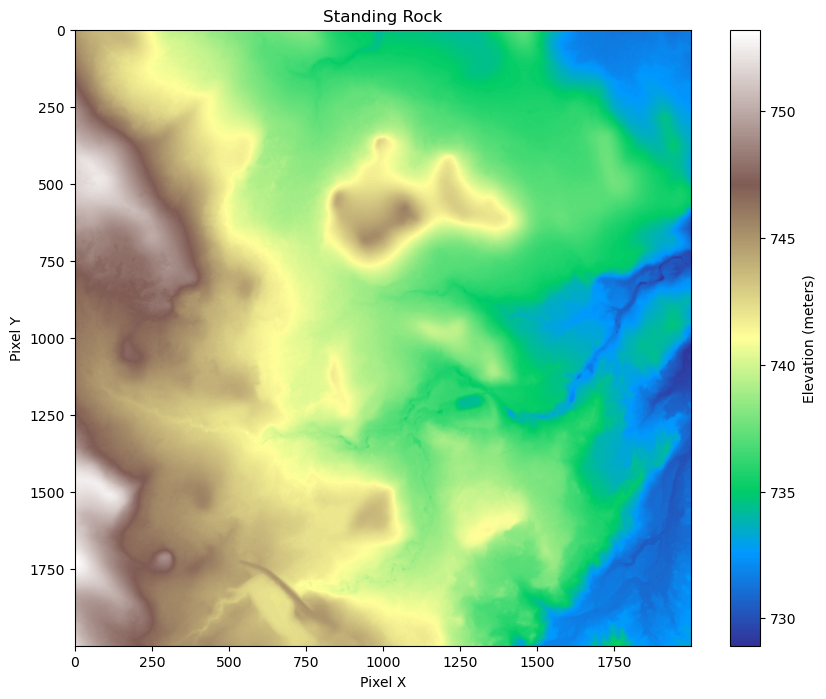

In [99]:
# Open the DEM using rasterio
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # Read the first band
    profile = src.profile  # Save profile if you need later for projection info

# Plot the DEM
plt.figure(figsize=(10, 8))
plt.imshow(dem, cmap='terrain')
plt.colorbar(label='Elevation (meters)')
plt.title('Standing Rock')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

In [ ]:
# Calculate statistics for the DEM
mean_elevation = np.mean(dem)
max_elevation = np.max(dem)
min_elevation = np.min(dem)

print(f"Mean Elevation: {mean_elevation} meters")
print(f"Max Elevation: {max_elevation} meters")
print(f"Min Elevation: {min_elevation} meters")


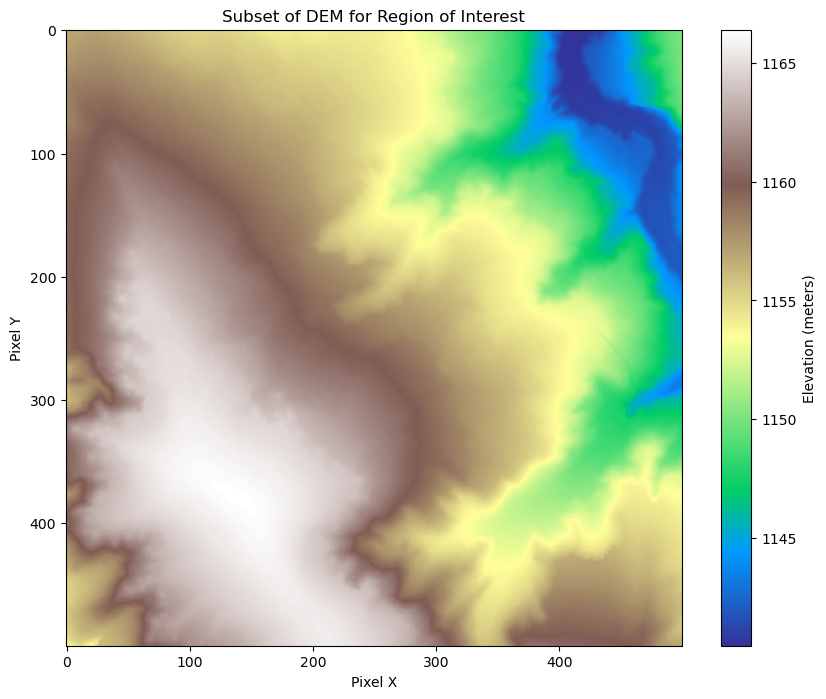

In [29]:
# Define the bounding box coordinates (row_min, row_max, col_min, col_max)
row_min, row_max = 1000, 1500  
col_min, col_max = 1000, 1500  

# Open the DEM and read it
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # Read the first band
    profile = src.profile

    # Slice the DEM data using the bounding box
    dem_subset = dem[row_min:row_max, col_min:col_max]

# Plot the subsetted DEM (this will be the area you're focusing on)
plt.figure(figsize=(10, 8))
plt.imshow(dem_subset, cmap='terrain')
plt.colorbar(label='Elevation (meters)')
plt.title('Subset of DEM for Region of Interest')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


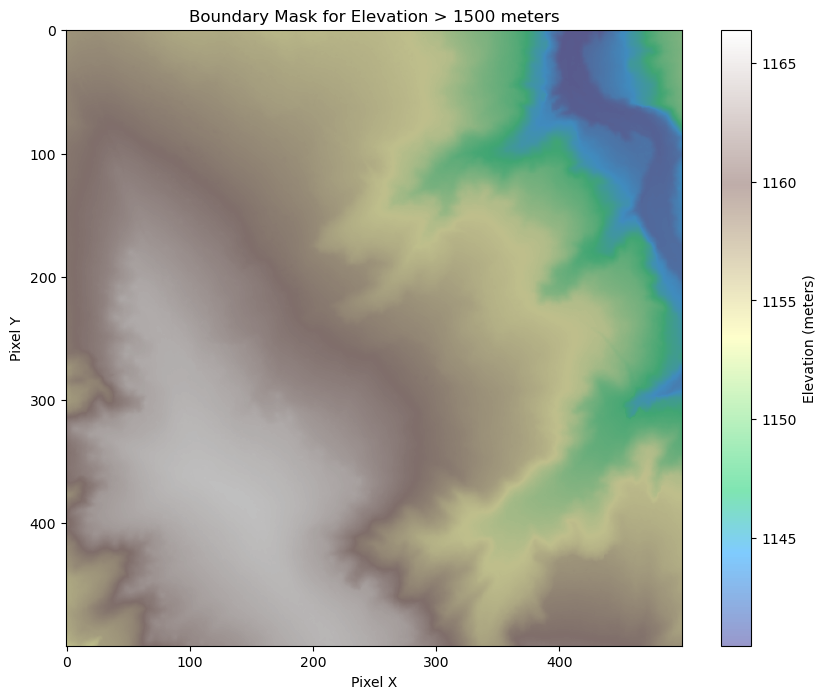

In [47]:
# Define an elevation threshold (e.g., 1500 meters)
threshold = 1500

# Create a binary mask based on the threshold
boundary_mask = dem_subset > threshold

# Plot the boundary mask over the DEM
plt.figure(figsize=(10, 8))
plt.imshow(boundary_mask, cmap='gray', alpha=0.5)  # Transparent overlay on DEM
plt.imshow(dem_subset, cmap='terrain', alpha=0.5)  # DEM data as background
plt.colorbar(label='Elevation (meters)')
plt.title(f'Boundary Mask for Elevation > {threshold} meters')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


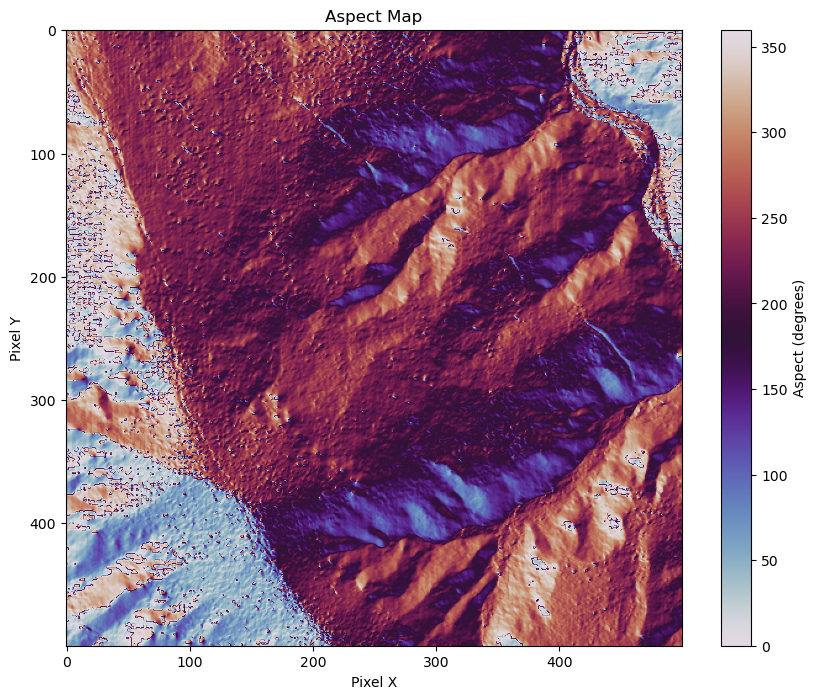

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the gradients (slope in x and y directions)
x, y = np.gradient(dem_subset)

# Calculate aspect
aspect = np.arctan2(-x, y)

# Convert from radians to degrees
aspect = np.degrees(aspect)

# Make sure aspect values are between 0-360 degrees
aspect = (aspect + 360) % 360

# Plot the aspect
plt.figure(figsize=(10, 8))
plt.imshow(aspect, cmap='twilight', vmin=0, vmax=360)
plt.colorbar(label='Aspect (degrees)')
plt.title('Aspect Map')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


In [97]:
# Path to your file
dem_path = r"C:\Users\Justina\habitat-suitability\data\USGS_OPR_SD_FY17_NRCS_Lidar_QSI_2017_D17_14TKR266042.tif"

# Open and inspect
with rasterio.open(dem_path) as src:
    print("Width:", src.width)
    print("Height:", src.height)
    print("Number of bands:", src.count)
    print("Data type:", src.dtypes)
    print("Coordinate Reference System (CRS):", src.crs)
    print("Bounds:", src.bounds)

Width: 2000
Height: 2000
Number of bands: 1
Data type: ('float32',)
Coordinate Reference System (CRS): EPSG:6343
Bounds: BoundingBox(left=266000.0, bottom=5042000.0, right=267000.0, top=5043000.0)
